In [3]:
import pandas as pd

In [4]:
df = pd.read_parquet('/Users/tanishqagarwal/Downloads/data.parquet') 

In [1]:
import pyarrow.parquet as pq

# Load the Parquet file
parquet_file = '/Users/tanishqagarwal/Downloads/data.parquet'
table = pq.read_table(parquet_file)

# Convert the table to a Pandas DataFrame
df = table.to_pandas()

# Display the DataFrame
print(df.head())

                     banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
2021-01-01 09:18:00   0.286104  0.199860   27
2021-01-01 09:19:00   0.285539  0.198951   27


In [6]:
# Calculate the spread
df['spread'] = df['banknifty'] - df['nifty']

In [7]:
def calculate_zscore(series, window_size):
    mean = series.rolling(window=window_size).mean()
    std = series.rolling(window=window_size).std()
    zscore = (series - mean) / std
    return zscore

In [8]:
# Define the rolling window size (adjust as needed)
window_size = 30
df['zscore'] = calculate_zscore(df['spread'], window_size)

In [9]:
# Define the z-score threshold for entering and exiting positions
entry_threshold = 1.0
exit_threshold = 0.0

# Generate trading signals
df['long_signal'] = df['zscore'] < -entry_threshold
df['short_signal'] = df['zscore'] > entry_threshold
df['exit_signal'] = (df['zscore'].abs() < exit_threshold) & (df['zscore'].shift(1).abs() >= exit_threshold)


In [11]:
# Define the position size
position_size = 1

# Calculate P/L based on the provided formula
df['pl'] = df['spread'] * (df['tte'] ** 0.7)

# Calculate daily P/L
df['daily_pl'] = position_size * df['spread'] * df['exit_signal'].shift(-1)

# Calculate cumulative P/L
df['cumulative_pl'] = df['daily_pl'].cumsum()


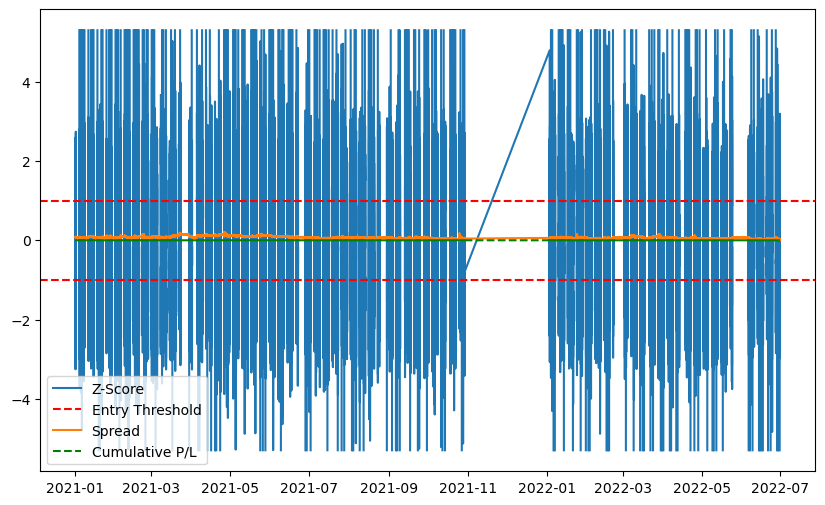

In [12]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['zscore'], label='Z-Score')
plt.axhline(entry_threshold, color='r', linestyle='--', label='Entry Threshold')
plt.axhline(-entry_threshold, color='r', linestyle='--')
plt.plot(df['spread'], label='Spread')
plt.plot(df['cumulative_pl'], label='Cumulative P/L', linestyle='--', color='g')
plt.legend()
plt.show()


/var/folders/n6/dc562gvj2_z2ymq85xcckjsr0000gn/T/ipykernel_61504/4210242285.py:7: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = df['daily_pl'].mean() / df['daily_pl'].std() * (252**0.5)  # Assuming 252 trading days in a year


Total P/L: nan
Sharpe Ratio: nan
Max Drawdown: 0.00


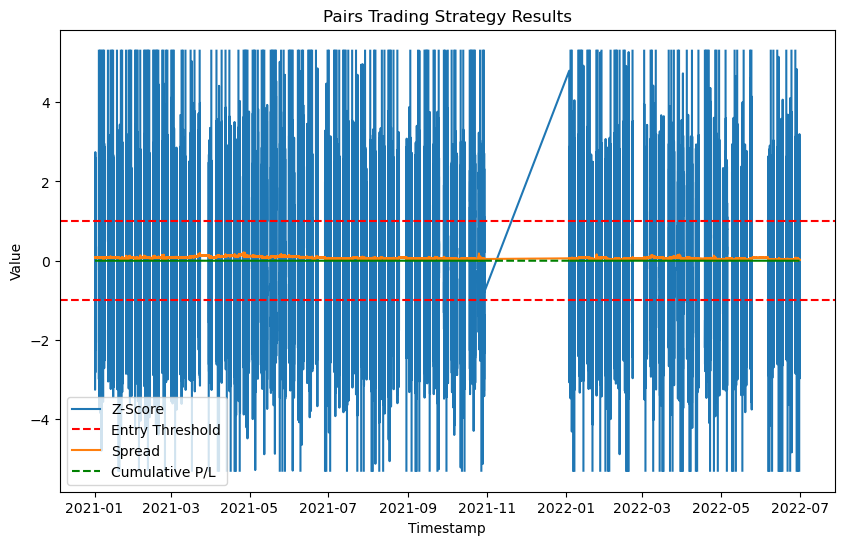

In [13]:
import matplotlib.pyplot as plt

# Analyze Results

# Calculate performance metrics
total_pl = df['cumulative_pl'].iloc[-1]
sharpe_ratio = df['daily_pl'].mean() / df['daily_pl'].std() * (252**0.5)  # Assuming 252 trading days in a year
max_drawdown = (df['cumulative_pl'] - df['cumulative_pl'].cummax()).min()

# Print performance metrics
print(f'Total P/L: {total_pl:.2f}')
print(f'Sharpe Ratio: {sharpe_ratio:.4f}')
print(f'Max Drawdown: {max_drawdown:.2f}')

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(df['zscore'], label='Z-Score')
plt.axhline(entry_threshold, color='r', linestyle='--', label='Entry Threshold')
plt.axhline(-entry_threshold, color='r', linestyle='--')
plt.plot(df['spread'], label='Spread')
plt.plot(df['cumulative_pl'], label='Cumulative P/L', linestyle='--', color='g')
plt.legend()
plt.title('Pairs Trading Strategy Results')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()
